### There seems to be duplicate images in train_images
- ('1562043567.jpg', '3551135685.jpg') and ('2252529694.jpg', '911861181.jpg')
- 1562043567.jpg and 3551135685.jpg seem to be given different labels.

### This notebook is based on [Let's find out duplicate images with imagehash](https://www.kaggle.com/appian/let-s-find-out-duplicate-images-with-imagehash)

In [3]:
import datetime
start_time = datetime.datetime.now()

import pandas as pd
import numpy as np
import os
import torch
import imagehash
import glob
import matplotlib.pyplot as plt

from tqdm.auto import  tqdm
from PIL import Image

In [13]:
TRAIN_DIR = '/home/rick/Dropbox/python_projects/data_science/Kaggle/cassava/BaseModel/data/cassava/raw/train/'
TRAIN_CSV_PATH = '/home/rick/Dropbox/python_projects/data_science/Kaggle/cassava/BaseModel/data/cassava/split/merged_5folds.csv'

In [10]:
train = pd.read_csv(TRAIN_CSV_PATH)

In [11]:
train

,image_id,class_id,source,stratify_group,fold,image_path
0,1000015157.jpg,0,2020,0_2020,3.0,/home/rick/Dropbox/python_projects/data_scienc...
1,1000201771.jpg,3,2020,3_2020,1.0,/home/rick/Dropbox/python_projects/data_scienc...
2,100042118.jpg,1,2020,1_2020,0.0,/home/rick/Dropbox/python_projects/data_scienc...
3,1000723321.jpg,1,2020,1_2020,3.0,/home/rick/Dropbox/python_projects/data_scienc...
4,1000812911.jpg,3,2020,3_2020,4.0,/home/rick/Dropbox/python_projects/data_scienc...
...,...,...,...,...,...,...
26332,train-cbb-114.jpg,0,2019,0_2019,1.0,/home/rick/Dropbox/python_projects/data_scienc...
26333,train-cmd-661.jpg,3,2019,3_2019,1.0,/home/rick/Dropbox/python_projects/data_scienc...
26334,train-cmd-1716.jpg,3,2019,3_2019,1.0,/home/rick/Dropbox/python_projects/data_scienc...
26335,train-healthy-236.jpg,4,2019,4_2019,0.0,/home/rick/Dropbox/python_projects/data_scienc...


In [14]:
funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
    ]
image_ids = []
hashes = []

for path in tqdm(glob.glob(TRAIN_DIR + '*.jpg' )):
    image = Image.open(path)
    image_id = os.path.basename(path)
    image_ids.append(image_id)
    hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

hashes_all = np.array(hashes)

In [15]:
hashes_all = torch.Tensor(hashes_all.astype(int)).cuda()

In [16]:
sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])

In [17]:
indices1 = np.where(sims > 0.9)
indices2 = np.where(indices1[0] != indices1[1])
image_ids1 = [image_ids[i] for i in indices1[0][indices2]]
image_ids2 = [image_ids[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([image_id1,image_id2])):True for image_id1, image_id2 in zip(image_ids1, image_ids2)}
print('found %d duplicates' % len(dups))

found 2 duplicates


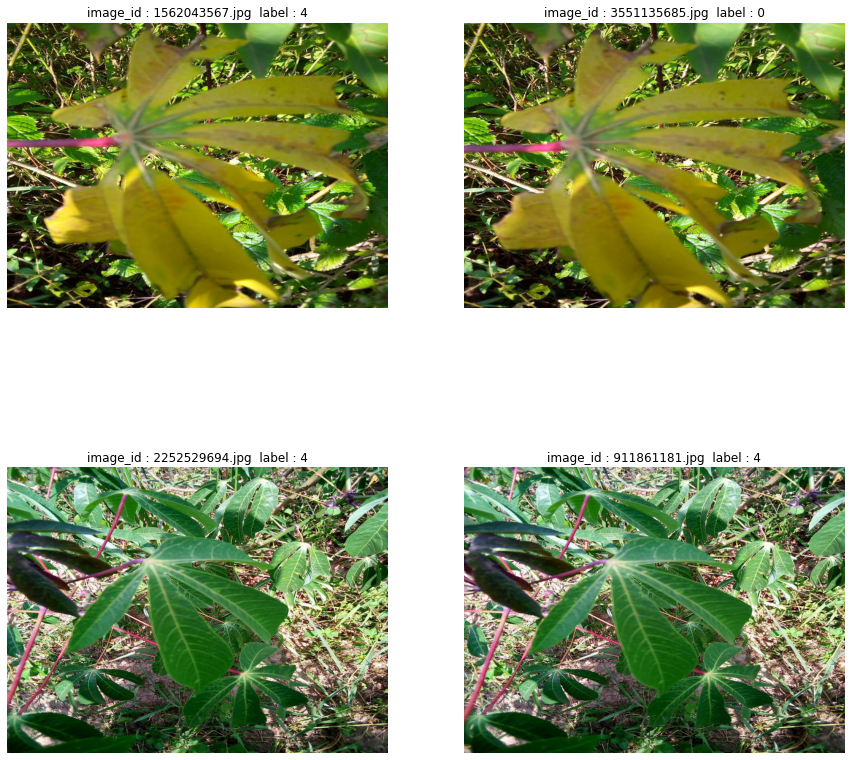

In [18]:
duplicate_image_ids = sorted(list(dups))

fig, axs = plt.subplots(2, 2, figsize=(15,15))

for row in range(2):
    for col in range(2):
        img_id = duplicate_image_ids[row][col]
        img = Image.open(TRAIN_DIR + img_id)
        label =str(train.loc[train['image_id'] == img_id].class_id.values[0])
        axs[row, col].imshow(img)
        axs[row, col].set_title("image_id : "+ img_id + "  label : " + label)
        axs[row, col].axis('off')

In [19]:
end_time = datetime.datetime.now()
print(end_time - start_time)

0:14:41.345240


Thank you for reading.